# Imports and Global Variables

In [0]:
!pip install pytorch-ignite

     |████████████████████████████████| 112kB 2.9MB/s 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ast import literal_eval
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from scipy import sparse

from sklearn.linear_model import RidgeCV

In [0]:
from ignite.handlers import ModelCheckpoint, EarlyStopping, TerminateOnNan
from ignite.engine import Engine, Events
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar

In [0]:
import torch
import torch.nn as nn
from torch import optim
import string
import random
import torch.utils.data as Data

In [0]:
from collections import OrderedDict
import locale
from locale import atof, atoi
locale.setlocale(locale.LC_NUMERIC, '')

'en_US.UTF-8'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
use_idf = True
max_features = 2**10
pca_components = 2**4
DRIVE_PATH = Path('/content/drive/My Drive/Thesis2019/')
NEIGHBOURHOOD_PROFILES_PATH = Path('neighbourhood-profiles-2016-csv.csv')
NEIGHBOURHOOD_PROFILES_PATH_OLD = Path('neighbourhood-data-2001-2011.xlsx')
DATA_DIR = DRIVE_PATH.joinpath('data_stripped')
use_cuda = True
years = [2011, 2016]

# Dataset Wrapper

Pytorch Dataset wrappers

In [0]:
class ReviewsVector(Data.Dataset):
    """Reviews Vector dataset."""

    def __init__(self, data):
        """
        Args: 
          data

        """
        self.shape = data.shape
        self.data = torch.tensor(data).type(torch.FloatTensor)
        if use_cuda and torch.cuda.is_available():
          self.data = self.data.cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class CensusVector(Data.Dataset):
  def __init__(self, data, reviews_embedding):
        """
        Args: 
          data

        """
        self.shape = data.shape
        self.data = torch.tensor(data).type(torch.FloatTensor)
        self.reviews_embedding = torch.tensor(reviews_embedding).type(torch.FloatTensor)
        if use_cuda and torch.cuda.is_available():
            self.data = self.data.cuda()
            self.reviews_embedding = self.reviews_embedding.cuda()
            
  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return {"data": self.data[idx],
              "reviews_embedding": self.reviews_embedding[idx]}

# Data Cleaning and Preprocessing

## Selecting and Matching Attributes for 2011 and 2016 data

Match census categories from different years.

In [0]:
nbh_profiles = pd.read_csv(DRIVE_PATH.joinpath(NEIGHBOURHOOD_PROFILES_PATH))
nbh_profiles_2011 = pd.read_excel(DRIVE_PATH.joinpath(NEIGHBOURHOOD_PROFILES_PATH_OLD), sheet_name='2011')

In [0]:
lang_2011 = nbh_profiles_2011[nbh_profiles_2011['Topic']=='Mother tongue']['Attribute'].to_numpy()
l_2011 = []
for i in lang_2011:
  l_2011.append(i.replace(' ', ''))
language_at_home_2011 = nbh_profiles_2011[(nbh_profiles_2011['Topic']=='Mother tongue')].drop(columns=['Category', 'Topic', 'City of Toronto'])
language_at_home_2011['Attribute'] = l_2011

In [0]:
lang_2016 = nbh_profiles[nbh_profiles['Topic']=='Mother tongue']['Characteristic'].to_numpy()
l_2016 = []
for i in lang_2016:
  l_2016.append(i.replace(' ', ''))
language_at_home_2016 = nbh_profiles[(nbh_profiles['Topic']=='Mother tongue')].drop(columns=['_id', 'Category', 'Topic', 'Data Source', 'City of Toronto'])
language_at_home_2016['Characteristic'] = l_2016

In [0]:
list(language_at_home_2016['Characteristic'].unique())

In [0]:
single_2011_idx = language_at_home_2011[language_at_home_2011['Attribute'] == 'Singleresponses'].index
multi_2011_idx = language_at_home_2011[language_at_home_2011['Attribute'] == 'Multipleresponses'].index

In [0]:
lath_2011_single = language_at_home_2011.loc[single_2011_idx[0]+1:multi_2011_idx[0]-1]

In [0]:
language_at_home_2011 = lath_2011_single

In [0]:
single_2016_idx = language_at_home_2016[language_at_home_2016['Characteristic'] == 'Singleresponses'].index
multi_2016_idx = language_at_home_2016[language_at_home_2016['Characteristic'] == 'Multipleresponses'].index
lath_2016_single = language_at_home_2016.loc[single_2016_idx[0]+1:multi_2016_idx[0]-1]

language_at_home_2016 = lath_2016_single

In [0]:
language_at_home_2011.sort_values(by='Attribute', inplace=True)
language_at_home_2016.sort_values(by='Characteristic', inplace=True)

In [0]:
language_at_home_2011.reset_index(inplace=True, drop=True)

In [0]:
language_at_home_2016.set_index('Characteristic', inplace=True)
language_at_home_2016 = language_at_home_2016.applymap(atoi)
language_at_home_2016.reset_index(inplace=True)

In [0]:
lath_2011 = pd.DataFrame()
lath_2016 = pd.DataFrame()
languages = []
languages_2011 = []

for index_2016, row_2016 in language_at_home_2016.iterrows():
  for index_2011, row_2011 in language_at_home_2011.iterrows():
    if row_2011['Attribute'] == row_2016['Characteristic']:
      languages.append(row_2016['Characteristic'])
      languages_2011.append(row_2011['Attribute'])
      lath_2011 = lath_2011.append(row_2011.iloc[1:], ignore_index=True)
      lath_2016 = lath_2016.append(row_2016.iloc[1:], ignore_index=True)

## Build Census datasets

In [0]:
lath_2011.to_csv(DRIVE_PATH.joinpath('mother_tongue_2011.csv'))
lath_2016.to_csv(DRIVE_PATH.joinpath('mother_tongue_2016.csv'))

## Load Built Census datasets

In [0]:
lath = {}

for year in years:
  lath[year] = pd.read_csv(DRIVE_PATH.joinpath('mother_tongue_{}.csv'.format(year)))
  lath[year].set_index('Unnamed: 0', inplace=True)
  lath[year] = lath[year].div(lath[year].sum(axis=1), axis=0)
  lath[year] = lath[year].replace(0,0.0000000001)
  lath[year].sort_index(inplace=True)

  # After plotting heatmaps, found this column to be an outlier, which has significant negative delta for all neighbourhoods
  # The reason is that in 2011, many different Chinese dialects are grouped into one 'Chinese,n.o.s.' group, while in 2016
  # A few different kind is separated out.
  lath[year].drop(columns='Chinese,n.o.s.', inplace=True) 

# Predicting Census Change

Census Change prediction is evaluated with Mean Total Absolute Error:

$Mean Total Absolute Error = $

$\frac{1}{\#Neighbourhoods}\sum_{Neighbourhoods} \sum_{categories} |Actual Proportion - Predicted Proportion|$

### Train-test split

Split by neighbourhoods

In [0]:
train_val_neighbourhoods, test_neighbourhoods = train_test_split(range(0, 140), test_size=0.15)

all_trains, all_vals = [], [] #Do random splits to cross validate
folds = 5

for i in range(folds):
  train_neighbourhoods, val_neighbourhoods = train_test_split(train_val_neighbourhoods, test_size=0.30)
  all_trains.append(train_neighbourhoods)
  all_vals.append(val_neighbourhoods)

### Baseline-Predicting no change

In [0]:
dummy_data = lath[2011].values
actual_data = lath[2016].values

In [0]:
# Training Error
np.abs(dummy_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.1198190504037125

In [0]:
# Testing Error
np.abs(dummy_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.11770054428156798

## Raw TF-IDF

### Load built csvs

In [0]:
reviews_all = {}
for year in [2011, 2016]:
  reviews_all[year] = pd.read_csv(DRIVE_PATH.joinpath('neighbourhood_reviews_{}.csv'.format(year)))
  reviews_all[year].set_index('Unnamed: 0', inplace=True)

reviews = {}
for year in [2011, 2016]:
  reviews[year] = ReviewsVector(reviews_all[year].T.values)

In [0]:
delta_census = lath[2016].values - lath[2011].values
delta_reviews = (reviews_all[2016].values - reviews_all[2011].values).T

### Multi-target Linear Regression

In [0]:
lr = RidgeCV(cv=5)
lr.fit(delta_reviews[train_val_neighbourhoods], delta_census[train_val_neighbourhoods])

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [0]:
predicted_change = lr.predict(delta_reviews)

In [0]:
# Training Error
np.abs((predicted_change[train_val_neighbourhoods]-delta_census[train_val_neighbourhoods])).sum(axis=1).mean()

0.12369619872283547

In [0]:
# Validation Error
np.abs((predicted_change[test_neighbourhoods]-delta_census[test_neighbourhoods])).sum(axis=1).mean()

0.1202751343426184

### Multi-target  Non-Linear Regression

In [0]:
class Decoder_C(nn.Module):
    def __init__(self, sizes, softmax=False):
        super(Decoder_C, self).__init__()
        sizes = sizes[::-1]
        layers_de = OrderedDict()

        for i in range(len(sizes)-2):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_de[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            layers_de[act_name] = nn.Tanh()

        layers_de['linear{}'.format(len(sizes)-1)] = nn.Linear(sizes[-2], sizes[-1])
        # layers_de['softmax'] = nn.Softmax(dim=1) # row sum to 1
        layers_de['tanh'] = nn.Tanh()
        if softmax:
          layers_de['softmax'] = nn.Softmax(dim=1)
        self.decoder = nn.Sequential(layers_de)

    def forward(self, encoded):
        return self.decoder(encoded) 

In [0]:
def criterion_c(data, decoded):
    mse_loss = nn.MSELoss()
    loss = mse_loss(data, decoded)
    return loss

In [0]:
def train_decoder(decoder, dataset, train_indices, test_indices, name='edu_auto'):
  optimizer_de = optim.Adam(decoder.parameters(), lr=0.001)
  scheduler_de = optim.lr_scheduler.ReduceLROnPlateau(optimizer_de, 'min', patience=20, min_lr=min_lr, factor=0.1)

  def process_function(engine, batch):
    decoder.train()
    optimizer_de.zero_grad()
    decoded = decoder(batch['reviews_embedding'])
    loss = criterion_c(decoded, batch['data'])
    loss.backward()

    optimizer_de.step()
    return loss.item()
  

  def eval_function(engine, batch):
    decoder.eval()

    with torch.no_grad():
        decoded = decoder(batch['reviews_embedding'])
        return decoded, batch['data']
  
  trainer = Engine(process_function)
  train_evaluator = Engine(eval_function)
  validation_evaluator = Engine(eval_function)

  metric = Loss(criterion_c)
  metric.attach(train_evaluator, 'loss')
  metric.attach(validation_evaluator, 'loss')

  training_losses = []
  validation_losses = []

  @trainer.on(Events.EPOCH_COMPLETED)
  def log_training_results(engine):
      train_evaluator.run(train_iterator)
      metrics = train_evaluator.state.metrics
      avg_loss = metrics['loss']    
      training_losses.append(avg_loss)
      print("Training Results - Epoch: {}  Avg loss: {:.10f}"
           .format(engine.state.epoch, avg_loss))
      
  def log_validation_results(engine):
      validation_evaluator.run(valid_iterator)
      metrics = validation_evaluator.state.metrics
      avg_loss = metrics['loss']
      validation_losses.append(avg_loss)

      print("Validation Results - Epoch: {}  Avg loss: {:.10f}"
            .format(engine.state.epoch, avg_loss))

  trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

  # Reduce on Plateau
  def average_loss(engine):
    print("Current lr: {}".format(optimizer_de.param_groups[0]['lr']))
    average_loss = engine.state.metrics['loss']
    scheduler_de.step(average_loss)

  validation_evaluator.add_event_handler(Events.COMPLETED, average_loss)
  
  # Early Stopping
  def score_function(engine):
      val_loss = engine.state.metrics['loss']
      return -val_loss

  handler = EarlyStopping(patience=30, score_function=score_function, trainer=trainer)
  validation_evaluator.add_event_handler(Events.COMPLETED, handler)

  # Model Checkpoint
  checkpointer = ModelCheckpoint(str(DRIVE_PATH.joinpath('models')), name, n_saved=1, create_dir=False, save_as_state_dict=True, require_empty=False)
  trainer.add_event_handler(Events.EPOCH_COMPLETED, checkpointer, {'decoder_c': decoder})

  train_iterator = Data.DataLoader(dataset, batch_size=1, drop_last=False, sampler=Data.SubsetRandomSampler(train_indices))
  valid_iterator = Data.DataLoader(dataset, batch_size=1, drop_last=False, sampler=Data.SubsetRandomSampler(test_indices))

  trainer.run(train_iterator, max_epochs=1000)
  return training_losses, validation_losses

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

#### With one layer

In [0]:
census_data = CensusVector(delta_census, delta_reviews)

sizes_c = [lath[2011].shape[1], delta_reviews.shape[1]]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
decoder_c

Decoder_C(
  (decoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=78, bias=True)
    (tanh): Tanh()
  )
)

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i], name='mt_raw')
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0000299603
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0000365727
Training Results - Epoch: 2  Avg loss: 0.0000254318
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0000354790
Training Results - Epoch: 3  Avg loss: 0.0000228996
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0000356740
Training Results - Epoch: 4  Avg loss: 0.0000213215
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0000352305
Training Results - Epoch: 5  Avg loss: 0.0000200729
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0000356980
Training Results - Epoch: 6  Avg loss: 0.0000190719
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0000368367
Training Results - Epoch: 7  Avg loss: 0.0000178601
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0000361702
Training Results - Epoch: 8  Avg loss: 0.0000173854
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0000366101
T

Text(0, 0.5, 'Loss')

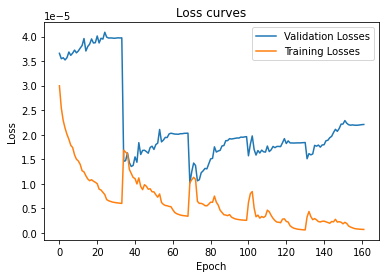

In [0]:
plt.plot(range(len(validation_losses)), validation_losses, range(len(training_losses)), training_losses)
plt.legend(['Validation Losses', 'Training Losses'])
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
# Test Loss
criterion_c(census_data.data[test_neighbourhoods], decoder_c(census_data.reviews_embedding[test_neighbourhoods]))

tensor(7.8127e-05, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
decoded_delta = decoder_c(census_data.reviews_embedding).cpu().detach().numpy()
actual_data = lath[2016].values
predicted_data = lath[2011].values+ decoded_delta

In [0]:
# Training error
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.02913268008830192

In [0]:
# Validation Error
np.abs((predicted_data[test_neighbourhoods]-actual_data[test_neighbourhoods])).sum(axis=1).mean()

0.2109503225502908

#### With Additional Layer

In [0]:
sizes_c = [lath[2011].shape[1], delta_reviews.shape[1]//2, delta_reviews.shape[1]]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
decoder_c

Decoder_C(
  (decoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=512, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=512, out_features=78, bias=True)
    (tanh): Tanh()
  )
)

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i], name='edu_raw_2')
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0000409032
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0000459455
Training Results - Epoch: 2  Avg loss: 0.0000260803
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0000382916
Training Results - Epoch: 3  Avg loss: 0.0000421449
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0000649226
Training Results - Epoch: 4  Avg loss: 0.0000258233
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0000487629
Training Results - Epoch: 5  Avg loss: 0.0000232668
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0000409320
Training Results - Epoch: 6  Avg loss: 0.0000208890
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0000389595
Training Results - Epoch: 7  Avg loss: 0.0000186613
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0000380415
Training Results - Epoch: 8  Avg loss: 0.0000179980
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0000411974
T

Text(0, 0.5, 'Loss')

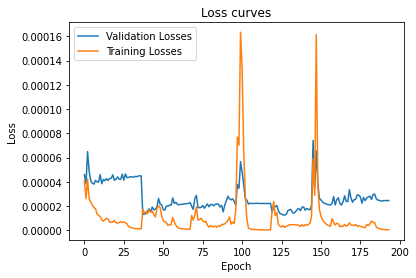

In [0]:
plt.plot(range(len(validation_losses)), validation_losses, range(len(training_losses)), training_losses)
plt.legend(['Validation Losses', 'Training Losses'])
plt.title('Loss curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [0]:
# Test Loss
criterion_c(census_data.data[test_neighbourhoods], decoder_c(census_data.reviews_embedding[test_neighbourhoods]))

tensor(8.3936e-05, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
decoded_delta = decoder_c(census_data.reviews_embedding).cpu().detach().numpy()
actual_data = lath[2016].values
predicted_data = lath[2011].values+ decoded_delta

In [0]:
# Training error
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.06355199197769561

In [0]:
# Validation Error
np.abs((predicted_data[test_neighbourhoods]-actual_data[test_neighbourhoods])).sum(axis=1).mean()

0.18067353250028173

## TF-IDF Autoencoder

In [0]:
class Encoder(nn.Module):
    def __init__(self, sizes):
        super(Encoder, self).__init__()
                
        layers_en = OrderedDict()       
        for i in range(len(sizes)-1):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_en[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            if i==0:
                nn.init.xavier_uniform_(layers_en[layer_name].weight)
            layers_en[act_name] = nn.Tanh() #-1 to 1
        
        self.encoder = nn.Sequential(layers_en)

    def forward(self, x):
        return self.encoder(x) 
    
class Decoder(nn.Module):
    def __init__(self, sizes):
        super(Decoder, self).__init__()
        
        sizes = sizes[::-1]
        
        layers_de = OrderedDict()
        for i in range(len(sizes)-2):
            layer_name = 'linear{}'.format(i+1)
            act_name = 'activation{}'.format(i+1)
            layers_de[layer_name] = nn.Linear(sizes[i], sizes[i+1])
            layers_de[act_name] = nn.Tanh()

        layers_de['linear{}'.format(len(sizes)-1)] = nn.Linear(sizes[-2], sizes[-1])
        layers_de['sigmoid'] = nn.Sigmoid() #0 to 1
        self.decoder = nn.Sequential(layers_de)

    def forward(self, encoded):
        return self.decoder(encoded) 

### Load trained model

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

In [0]:
sizes_r = [max_features, 2**10, 2**8, pca_components]
encoder = Encoder(sizes_r)
decoder = Decoder(sizes_r)

if use_cuda and torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()

In [0]:
encoder.load_state_dict(torch.load('/content/drive/My Drive/Thesis2019/models/review_encoder2_500.pth'))
encoder.eval()
encoder.to(torch.device("cuda"))

decoder.load_state_dict(torch.load('/content/drive/My Drive/Thesis2019/models/review_decoder2_500.pth'))
decoder.eval()
decoder.to(torch.device("cuda"))

Decoder(
  (decoder): Sequential(
    (linear1): Linear(in_features=16, out_features=256, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=256, out_features=1024, bias=True)
    (activation2): Tanh()
    (linear3): Linear(in_features=1024, out_features=1024, bias=True)
    (sigmoid): Sigmoid()
  )
)

### Multi-target Linear Regression

In [0]:
lr = RidgeCV(cv=5)
delta_census = lath[2016].values - lath[2011].values
delta_embedding = (encoder(reviews[2016].data) - encoder(reviews[2011].data)).detach().cpu().numpy()

In [0]:
lr.fit(delta_embedding[train_val_neighbourhoods], delta_census[train_val_neighbourhoods])

In [0]:
predicted_change = lr.predict(delta_embedding[train_val_neighbourhoods])

In [0]:
# Training Error
np.abs((predicted_change-delta_census[train_val_neighbourhoods])).sum(axis=1).mean()

0.12207533693150446

In [0]:
# Validation Error
np.abs((lr.predict(delta_embedding[test_neighbourhoods])-delta_census[test_neighbourhoods])).sum(axis=1).mean()

0.12103099693519383

### Multi-target Non-Linear Regression (Census Decoder)

In [0]:
delta_embedding = encoder(reviews[2016].data) - encoder(reviews[2011].data)
delta_census = lath[2016].values - lath[2011].values
census_data = CensusVector(delta_census, delta_embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [0]:
sizes_c = [lath[2011].shape[1], pca_components]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i])
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0100058220
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0112684306
Training Results - Epoch: 2  Avg loss: 0.0043881810
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0057412855
Training Results - Epoch: 3  Avg loss: 0.0023859152
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0036368536
Training Results - Epoch: 4  Avg loss: 0.0015832255
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0027059970
Training Results - Epoch: 5  Avg loss: 0.0012104704
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0022078647
Training Results - Epoch: 6  Avg loss: 0.0009680197
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0018602075
Training Results - Epoch: 7  Avg loss: 0.0007934476
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0015808542
Training Results - Epoch: 8  Avg loss: 0.0006692975
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0013835546
T

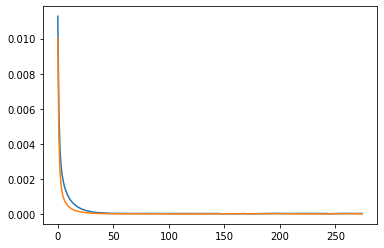

In [0]:
plt.plot(range(len(validation_losses)), validation_losses, range(len(training_losses)), training_losses)
plt.savefig(DRIVE_PATH.joinpath('loss.png'))

In [0]:
# Test Loss
criterion_c(census_data.data[test_neighbourhoods], decoder_c(census_data.reviews_embedding[test_neighbourhoods]))

tensor(4.1247e-05, device='cuda:0', grad_fn=<MeanBackward0>)

In [0]:
decoded_delta = decoder_c(delta_embedding).cpu().detach().numpy()
actual_data = lath[2016].values
predicted_data = lath[2011].values+ decoded_delta

In [0]:
# Testing error
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.14819325991617496

In [0]:
# Training error
np.abs(predicted_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.17444296065207543

## ELMO

### Load trained model and built csvs

In [0]:
reviews_elmo_all = {}
reviews_elmo = {}
for year in [2011, 2016]:
  reviews_elmo_all[year] = pd.read_csv(DRIVE_PATH.joinpath('elmo_reviews_{}.csv'.format(year)))
  reviews_elmo_all[year].set_index('Unnamed: 0', inplace=True)
  reviews_elmo[year] = ReviewsVector(reviews_elmo_all[year].T.values)

In [0]:
delta_embedding = reviews_elmo[2016].data.T - reviews_elmo[2011].data.T
delta_census = lath[2016].values - lath[2011].values
census_data = CensusVector(delta_census, delta_embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Multi-target Linear Regression

In [0]:
lingreg = RidgeCV(cv=5)
lingreg.fit(delta_embedding[train_val_neighbourhoods].detach().cpu().numpy(), delta_census[train_val_neighbourhoods])

In [0]:
predicted_change = lingreg.predict(delta_embedding.detach().cpu().numpy())

In [0]:
# Training Error
np.abs((predicted_change[train_val_neighbourhoods]-delta_census[train_val_neighbourhoods])).sum(axis=1).mean()

0.11931084794328486

In [0]:
# Testing Error
np.abs((predicted_change[test_neighbourhoods]-delta_census[test_neighbourhoods])).sum(axis=1).mean()

0.121899702279359

### Multi-target Non-Linear Regression

#### With one layer

In [0]:
lr = 0.001
patience = 20
min_lr = 0.00001

In [0]:
sizes_c = [lath[2011].shape[1], reviews_elmo_all[2016].shape[1]]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i], name='edu_elmo')
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0020757126
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0003870178
Training Results - Epoch: 2  Avg loss: 0.0057896024
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0021175532
Training Results - Epoch: 3  Avg loss: 0.0021644640
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0003045417
Training Results - Epoch: 4  Avg loss: 0.0026804343
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0006112208
Training Results - Epoch: 5  Avg loss: 0.0038239381
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0008091827
Training Results - Epoch: 6  Avg loss: 0.0031671803
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0006739741
Training Results - Epoch: 7  Avg loss: 0.0042581016
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0012319483
Training Results - Epoch: 8  Avg loss: 0.0138879325
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0147209736
T

In [0]:
decoded_delta = decoder_c(delta_embedding).cpu().detach().numpy()
predicted_data = lath[2011].values + decoded_delta

In [0]:
# Training Error
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.2959962495566842

In [0]:
# Testing Error
np.abs(predicted_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.4453066074260302

#### With Additional Layer

In [0]:
sizes_c = [lath[2011].shape[1], reviews_elmo_all[2016].shape[1]//2, reviews_elmo_all[2016].shape[1]]
decoder_c = Decoder_C(sizes_c)

if use_cuda and torch.cuda.is_available():
    decoder_c.cuda()

In [0]:
decoder_c

Decoder_C(
  (decoder): Sequential(
    (linear1): Linear(in_features=1024, out_features=512, bias=True)
    (activation1): Tanh()
    (linear2): Linear(in_features=512, out_features=78, bias=True)
    (tanh): Tanh()
  )
)

In [0]:
validation_losses, training_losses = [], []
for i in range(folds):
  print('FOLD', i)
  t, v = train_decoder(decoder_c, census_data, all_trains[i], all_vals[i], name='edu_elmo')
  training_losses.extend(t)
  validation_losses.extend(v)

FOLD 0
Training Results - Epoch: 1  Avg loss: 0.0012632927
Current lr: 0.001
Validation Results - Epoch: 1  Avg loss: 0.0005507670
Training Results - Epoch: 2  Avg loss: 0.0142277758
Current lr: 0.001
Validation Results - Epoch: 2  Avg loss: 0.0053524103
Training Results - Epoch: 3  Avg loss: 0.0038584909
Current lr: 0.001
Validation Results - Epoch: 3  Avg loss: 0.0008690110
Training Results - Epoch: 4  Avg loss: 0.0028182838
Current lr: 0.001
Validation Results - Epoch: 4  Avg loss: 0.0014757848
Training Results - Epoch: 5  Avg loss: 0.0034881001
Current lr: 0.001
Validation Results - Epoch: 5  Avg loss: 0.0020770685
Training Results - Epoch: 6  Avg loss: 0.0015096117
Current lr: 0.001
Validation Results - Epoch: 6  Avg loss: 0.0004022144
Training Results - Epoch: 7  Avg loss: 0.0041949020
Current lr: 0.001
Validation Results - Epoch: 7  Avg loss: 0.0044009521
Training Results - Epoch: 8  Avg loss: 0.0096808845
Current lr: 0.001
Validation Results - Epoch: 8  Avg loss: 0.0066825170
T

In [0]:
decoded_delta = decoder_c(delta_embedding).cpu().detach().numpy()
predicted_data = lath[2011].values + decoded_delta

In [0]:
np.abs(predicted_data[train_val_neighbourhoods] - actual_data[train_val_neighbourhoods]).sum(axis=1).mean()

0.14882985725767778

In [0]:
np.abs(predicted_data[test_neighbourhoods] - actual_data[test_neighbourhoods]).sum(axis=1).mean()

0.20874490086198058

## Results Summary

<table>
    <thead>
        <tr>
            <th rowspan=2>Model</th>
            <th rowspan=2> "No change" </th>
            <th colspan=2>TF-IDF Autoencoder</th>
            <th colspan=2>ELMO</th>
        </tr>
        <tr>
            <th>LR</th>
            <th>NLR1</th>
            <th>LR</th>
            <th>NLR1</th>
            <th>NLR2</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Training MAE</td>
            <td>11.92%</td>
            <td>7.94%</td>
            <td>8.22%</td>
            <td>8.01%</td>
            <td>5.62%</td>
            <td>5.62%</td>
        </tr>
        <tr>
            <td>Testing MAE</td>
            <td>12.11%</td>
            <td>10.07%</td>
            <td>9.33%</td>
            <td>8.01%</td>
            <td>12.55%</td>
            <td>9.25%</td>
        </tr>
</tbody>
</table>